In [190]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [191]:
reflectanceFilePath = 'EMIT_L2A_RFL_001_20220827T104728_2223907_002.nc'
mineralFilePath = 'EMIT_L2B_MIN_001_20220827T104728_2223907_002.nc'

In [192]:
refl = xr.open_dataset(reflectanceFilePath)

In [193]:
minerals = xr.open_dataset(mineralFilePath)

In [194]:
refl = refl.reflectance.dropna(dim="downtrack", how='any')

In [195]:
minerals = minerals.group_1_mineral_id.dropna(dim="downtrack", how='any')

In [196]:
cropDowntrack = int(refl.shape[0]/4)
cropCrosstrack = int(refl.shape[1]/4)

In [197]:
x_train = refl.sel(downtrack=slice(0, cropDowntrack), crosstrack=slice(0, cropCrosstrack)).values
y_train = minerals.sel(downtrack=slice(0, cropDowntrack), crosstrack=slice(0, cropCrosstrack)).values

In [198]:
# x_test = refl.sel(downtrack=slice(0, cropDowntrack)).values
# y_test = minerals.sel(downtrack=slice(0, cropDowntrack)).values

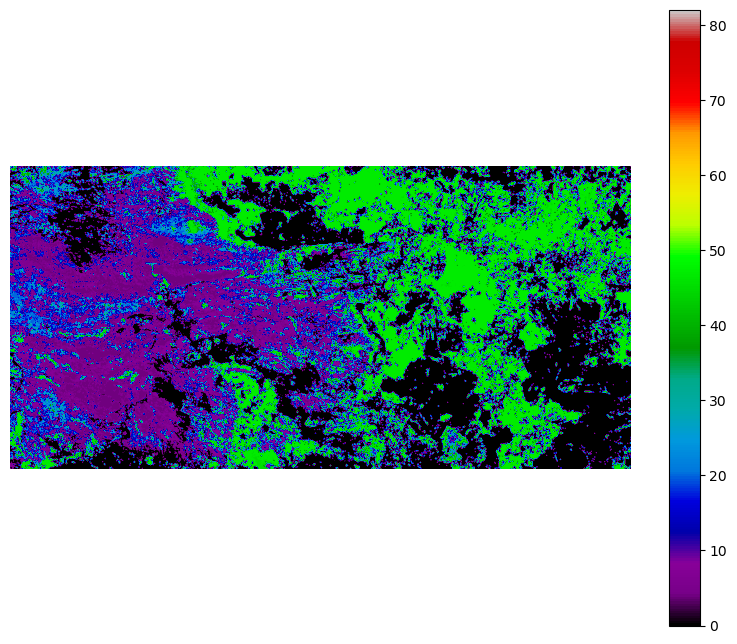

In [199]:
plt.figure(figsize=(10, 8))
plt.imshow(minerals.values, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.show()

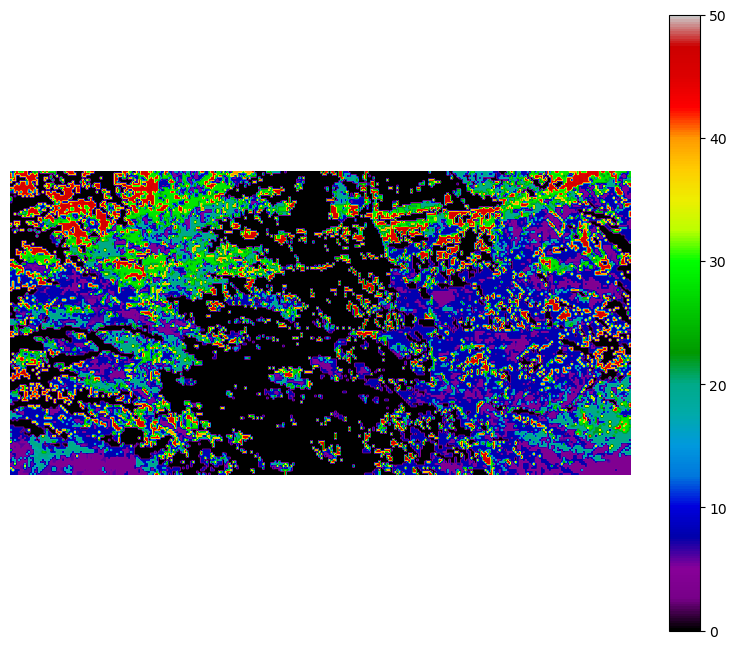

In [200]:
plt.figure(figsize=(10, 8))
plt.imshow(y_train, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.show()

In [201]:
del refl
del minerals

In [202]:
def preProcessData(x,
                   y,
                   removeSingleInstanceValues = True,
                   scaleData = True):
	X = x.reshape(-1, x.shape[2])
	y = y.ravel()
	X = pd.DataFrame(X)
	X['gt'] = y
	X = X.loc[:, ~(X == -0.01).any()]
	X = X.query('gt != 0')
	X = X.dropna()
	if(removeSingleInstanceValues):
		X = X[X['gt'].map(X['gt'].value_counts()) > 2]
	y = X.pop('gt').values
	if(scaleData):
		from sklearn.preprocessing import StandardScaler
		scaler = StandardScaler()
		X = scaler.fit_transform(X)
	return X, y

In [203]:
x_train, y_train = preProcessData(x_train, y_train)

In [204]:
print(x_train.shape)

(28731, 244)


In [205]:
from collections import Counter
counter = Counter(y_train)
print(counter)
len(counter)

Counter({8.0: 9833, 20.0: 4123, 28.0: 4088, 4.0: 4051, 45.0: 3777, 47.0: 1458, 6.0: 811, 40.0: 414, 18.0: 81, 41.0: 35, 22.0: 18, 13.0: 16, 17.0: 15, 7.0: 11})


14

In [206]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.5, random_state=42, stratify=y_train)
print(x_train.shape)

(14365, 244)


In [207]:
def class_weight(labels_dict,mu=0.15):
	total = np.sum(np.fromiter(labels_dict.values(), dtype=int))
	keys = labels_dict.keys()
	weight = dict()
	for i in keys:
		score = np.log(mu*total/int(labels_dict[i]))
		weight[i] = score if score > 1 else 1
	return weight

In [208]:
weights = class_weight(Counter(y_train))

In [209]:
from sklearn.svm import SVC
model = SVC(C=10, gamma=1, kernel='linear', class_weight = weights)
model.fit(x_train, y_train)

SVC(C=10,
    class_weight={4.0: 1, 6.0: 1.6715429194209694, 7.0: 5.8836705172994535,
                  8.0: 1, 13.0: 5.595988444847673, 17.0: 5.595988444847673,
                  18.0: 3.961857919823201, 20.0: 1, 22.0: 5.478205409191289,
                  28.0: 1, 40.0: 2.3427111932621396, 41.0: 4.785058228631344,
                  45.0: 1, 47.0: 1.0837562545188506},
    gamma=1, kernel='linear')

In [210]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
pred = model.predict(x_test)
model_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
print("Test Result:n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:n{model_report}")

Test Result:n================================================
Accuracy Score: 90.06%
_______________________________________________
CLASSIFICATION REPORT:n                   4.0         6.0  7.0          8.0  13.0  17.0       18.0  \
precision     0.909091    0.688699  0.8     0.934647   0.0   0.0   0.571429   
recall        0.903258    0.795567  0.8     0.945292   0.0   0.0   0.600000   
f1-score      0.906165    0.738286  0.8     0.939939   0.0   0.0   0.585366   
support    2026.000000  406.000000  5.0  4917.000000   8.0   7.0  40.000000   

                  20.0      22.0         28.0        40.0       41.0  \
precision     0.910107  0.666667     0.857143    0.687204   0.533333   
recall        0.869059  0.444444     0.860078    0.700483   0.470588   
f1-score      0.889109  0.533333     0.858608    0.693780   0.500000   
support    2062.000000  9.000000  2044.000000  207.000000  17.000000   

                  45.0        47.0  accuracy     macro avg  weighted avg  
precision   

c:\Users\jarbe\anaconda3\envs\emit\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jarbe\anaconda3\envs\emit\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jarbe\anaconda3\envs\emit\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [211]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100], 
#               'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 
#               'kernel': ['rbf', 'poly', 'linear']} 

# grid = GridSearchCV(SVC(class_weight = weights), param_grid, refit=True, verbose=2, n_jobs=- 1)

# grid.fit(x_train, y_train) 

# best_params = grid.best_params_
# print(f"Best params: {best_params}")

# svm_clf = SVC(class_weight = weights, **best_params)
# svm_clf.fit(x_train, y_train)

# pred = svm_clf.predict(x_test)
# model_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
# print("Test Result:n================================================")        
# print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
# print("_______________________________________________")
# print(f"CLASSIFICATION REPORT:n{model_report}")

In [212]:
model_report

,4.0,6.0,7.0,8.0,13.0,17.0,18.0,20.0,22.0,28.0,40.0,41.0,45.0,47.0,accuracy,macro avg,weighted avg
precision,0.909091,0.688699,0.8,0.934647,0.0,0.0,0.571429,0.910107,0.666667,0.857143,0.687204,0.533333,0.925159,0.907713,0.900599,0.670799,0.900686
recall,0.903258,0.795567,0.8,0.945292,0.0,0.0,0.600000,0.869059,0.444444,0.860078,0.700483,0.470588,0.922710,0.903978,0.900599,0.658247,0.900599
f1-score,0.906165,0.738286,0.8,0.939939,0.0,0.0,0.585366,0.889109,0.533333,0.858608,0.693780,0.500000,0.923933,0.905842,0.900599,0.662454,0.900435
support,2026.000000,406.000000,5.0,4917.000000,8.0,7.0,40.000000,2062.000000,9.000000,2044.000000,207.000000,17.000000,1889.000000,729.000000,0.900599,14366.000000,14366.000000


<Axes: >

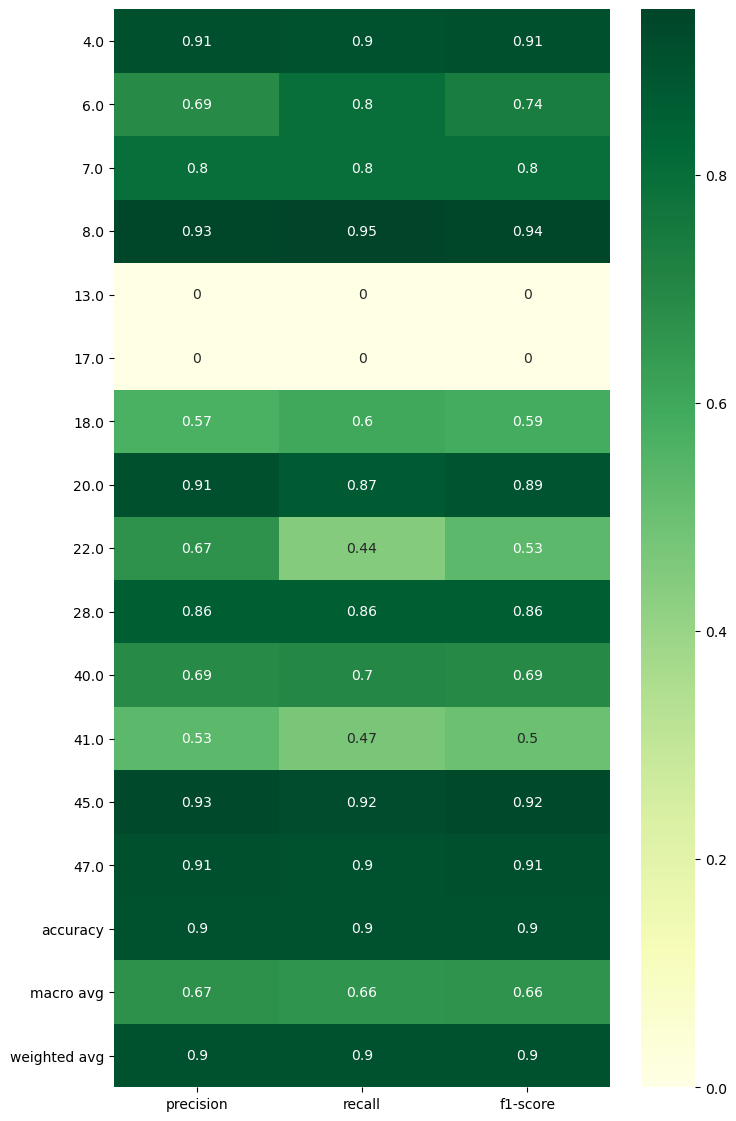

In [213]:
# .iloc[:-1, :] to exclude support
plt.figure(figsize=(8, 14))
sns.heatmap(pd.DataFrame(model_report).iloc[:-1, :].T, annot=True, cmap="YlGn")

In [ ]:
accuracy = 0

for i in range(0, 10):
    print(i)
    x_t, x_ts, y_t, y_ts = train_test_split(x_train, y_train, test_size=0.5, random_state=i)
    svm_clf = SVC(class_weight = weights, **best_params)
    svm_clf.fit(x_t, y_t)
    pred = svm_clf.predict(x_ts)
    acc = accuracy_score(y_ts, pred) * 100
    print(acc)
    accuracy += acc
accuracy = accuracy / 10
print(accuracy)